In [1]:
#| label: load-pkgs

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

## Dataset Setup 


In [2]:
# Load the dataset
df = pd.read_csv(".././data/creditcard_2023.csv")

# Selected features
features = ["V10", "V4", "V14", "V12", "V11", "V17", "V16", "V7", "V3", "V2"]

# Features data
X = df[features]

# Target variable
y = df['Class']


# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

## XGBoost classifier


In [3]:
#| label: XGBoost classifier

# Split the data into training and testing sets
random_state = 42
test_size = 0.2

# Initialize the XGBoost classifier
xgb = XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss')

# Set up the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# Perform Randomized Search
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10, scoring='roc_auc', cv=3, verbose=1, random_state=random_state)
random_search.fit(X_train, y_train)

# Best estimator
best_xgb = random_search.best_estimator_

# Make predictions
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1]

# Compute metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)

# Print the results
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC:", auc_roc)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Confusion Matrix:
 [[56522   228]
 [   84 56892]]
Accuracy: 0.9972565640222992
Precision: 0.9960084033613446
Recall: 0.9985256950294861
F1 Score: 0.9972654606647035
AUC-ROC: 0.999924558698183


##  KNN classifier


Confusion Matrix:
 [[56459   291]
 [    0 56976]]
Accuracy: 0.9974412183669521
Precision: 0.9949185394729949
Recall: 1.0
F1 Score: 0.9974527979832463
AUC-ROC: 0.9989600737678249


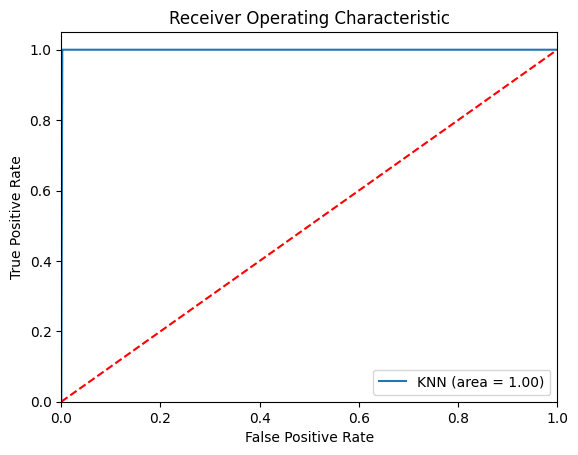

In [5]:
#| label: KNN classifier

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Creating the KNN model

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predicting the Test set results
y_pred = knn.predict(X_test_scaled)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Precision, Recall, and F1 Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# ROC-AUC
y_probs = knn.predict_proba(X_test_scaled)[:, 1]  # Probability estimates for the positive class
auc = roc_auc_score(y_test, y_probs)
print("AUC-ROC:", auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label='KNN (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Random Forest classifier


In [6]:
#| label: Random Forest classifier

# Train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)[:, 1]

# Calculating performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC: {roc_auc}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(cm)

Accuracy: 0.9995163814782899
Precision: 0.9992457066676023
Recall: 0.9997893850042123
ROC-AUC: 0.9999694900519207
F1 Score: 0.999517471903705
Confusion Matrix:
[[56707    43]
 [   12 56964]]
